# GPU 연동 확인

In [2]:
import keras
import tensorflow as tf
tf.test.gpu_device_name()
tf.config.list_physical_devices('GPU')

[]

In [5]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt


# from tqdm import tqdm_notebook as tqdm
from sklearn.utils import class_weight, shuffle
# from tensorflow.keras.utils import to_categorical
from keras import applications
from keras import optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

# version
- numpy: 1.21.1
- pandas: 1.3.5
- cv2: 4.0.1
- matplotlib: 3.5.0
- tqdm: 4.62.3
- sklearn: 1.0.2
- keras: 2.6.0
- tensorflow: 2.8.0

In [ ]:
# 폴더 이름
IMG_FOLDER_PATH = './raw-img/' 
foldernames = os.listdir(IMG_FOLDER_PATH)
categories = []
files = []
i = 0

# 이미지 카테고리 추출 및
# 이미지 파일 추출
for k, folder in enumerate(foldernames):
    filenames = os.listdir(IMG_FOLDER_PATH + folder);
    for file in filenames:
        files.append(IMG_FOLDER_PATH + folder + "/" + file)
        categories.append(k)

# 데이터 프레임 생성
df = pd.DataFrame({
    'filename': files,
    'category': categories
})

# 훈련 데이터 프레임 생성
train_df = pd.DataFrame(columns=['filename', 'category'])

# 카테고리별 데이터 500개씩 추출
for i in range(10):
    train_df = train_df.append(df[df.category == i].iloc[:500,:])

# 데이터 확인
train_df.head()
train_df = train_df.reset_index(drop=True)
train_df

# 총 row : 5_000

,filename,category
0,./raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg,0
1,./raw-img/cane/OIP---A27bIBcUgX1qkbpZOPswHaFS....,0
2,./raw-img/cane/OIP---cByAiEbIxIAleGo9AqOQAAAA....,0
3,./raw-img/cane/OIP---ZIdwfUcJeVxnh47zppcQHaFj....,0
4,./raw-img/cane/OIP---ZRsOF7zsMqhW30WeF8-AHaFj....,0
...,...,...
4995,./raw-img/scoiattolo/OIP-DLuAMgbGGOGW0r49pIsMt...,9
4996,./raw-img/scoiattolo/OIP-DlVY-0x9uqexVnZY_1TXx...,9
4997,./raw-img/scoiattolo/OIP-DlwICIPtlrWDrdz6v-QVC...,9
4998,./raw-img/scoiattolo/OIP-DL_IigTXGyMfa6OEnyQF3...,9


In [ ]:
x = train_df['filename']
y = train_df['category']

# 데이터 섞기
x, y = shuffle(x, y, random_state=8)
print(x, y)

2735                            ./raw-img/gatto/1328.jpeg
4027    ./raw-img/ragno/e834b3082ef6073ed1584d05fb1d4e...
1648    ./raw-img/farfalla/ea36b10b2df3053ed1584d05fb1...
1746    ./raw-img/farfalla/ea36b70c2ff5063ed1584d05fb1...
4640    ./raw-img/scoiattolo/OIP-3XJVZ5mYfXAckzdudRWZc...
                              ...                        
2181                           ./raw-img/gallina/232.jpeg
2409                           ./raw-img/gallina/692.jpeg
2033                          ./raw-img/gallina/1051.jpeg
1364    ./raw-img/elefante/ef33b10f2dfc1c22d2524518b74...
4547    ./raw-img/scoiattolo/OIP-0nN4r60Gvwu6tKx-yEIUF...
Name: filename, Length: 5000, dtype: object 2735    5
4027    8
1648    3
1746    3
4640    9
       ..
2181    4
2409    4
2033    4
1364    2
4547    9
Name: category, Length: 5000, dtype: object


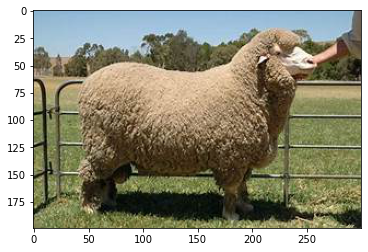

(199, 300, 3)
tile_size: (256, 169)


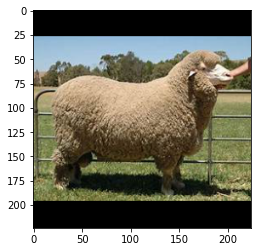

(224, 224, 3)


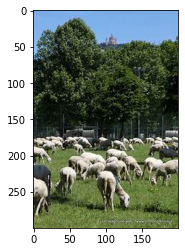

(300, 200, 3)
tile_size: (170, 256)


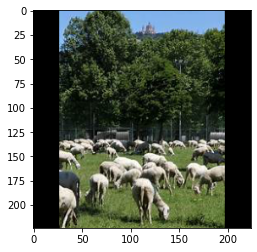

(224, 224, 3)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# 이미지 읽는 라이브러리

# 이미지 전처리 확인하기

# ------------------------------------------------------------------- #
def centering_image(img):
    size = [256,256]
    img_size = img.shape[:2]
    
    # centering
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized
# ------------------------------------------------------------------- #

# 가로 이미지 > img.shape[1] 더큼
test_img = './raw-img/pecora/OIP-jhqZKyUXtnx539TSBBK7qQHaE6.jpeg'
img = mpimg.imread(test_img)
plt.imshow(img)
plt.show()
print(img.shape)

# 가로 이미지 변형 < 정사각형 비율로 변경 > 224 x 224
tile_size = (256, int(img.shape[0]*256/img.shape[1]))
print("tile_size:", tile_size)
img = centering_image(cv2.resize(img, dsize=tile_size))
img = img[16:240, 16:240]
plt.imshow(img)
plt.show()
print(img.shape)

# 세로 이미지  > img.shape[0] 더큼
test_img = "./raw-img/pecora/OIP-gbxNqYWOnt5R3tvyulJQuwHaLH.jpeg"
img = mpimg.imread(test_img)
plt.imshow(img)
plt.show()
print(img.shape)

# 세로 이미지 변형 < 정사각형 비율로 변경 > 224 x 224
tile_size = (int(img.shape[1]*256/img.shape[0]),256)
print("tile_size:", tile_size)
img = centering_image(cv2.resize(img, dsize=tile_size))
img = img[16:240, 16:240]
plt.imshow(img)
plt.show()
print(img.shape)

In [ ]:
# 모든 이미지에 적용
images = []
for i, file_path in enumerate(train_df.filename.values):
    #read image
    img = cv2.imread(file_path) # 이미지 읽기
    # BGR 사진을 RGB 사진으로 변환하기
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #resize : 크기 조정
    if(img.shape[0] > img.shape[1]): # 가로 / 세로 이미지 판별
        # 가로 이미지
        tile_size = (int(img.shape[1]*256/img.shape[0]),256)
    else:
        # 세로 이미지
        tile_size = (256, int(img.shape[0]*256/img.shape[1]))

    #centering
    img = centering_image(cv2.resize(img, dsize=tile_size))

    #out put 224*224px 
    img = img[16:240, 16:240]
    images.append(img)

images = np.array(images)

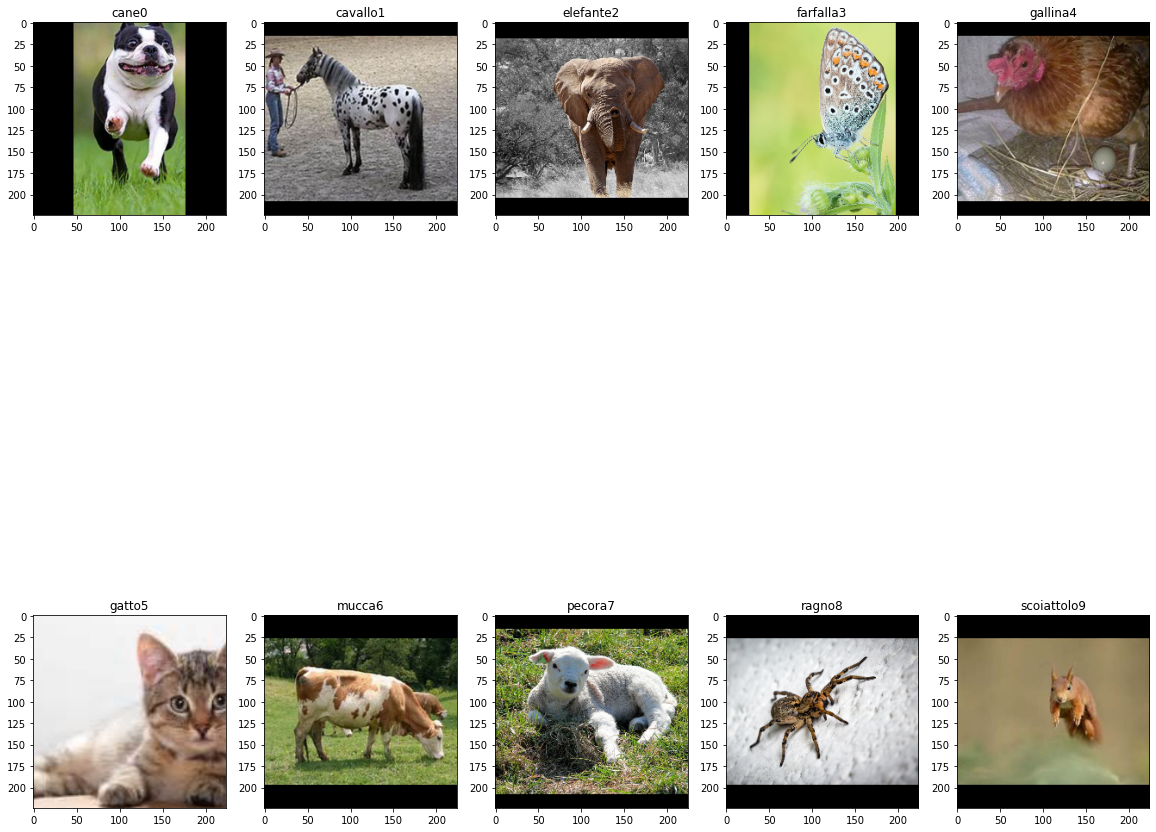

In [ ]:
# 시각화 레이아웃 설정
rows, cols = 2, 5
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,20))

for i in range(10):
    path = train_df[train_df.category == i].values[2]
#     image = cv2.imread(path[0])/
    axes[i//cols, i%cols].set_title(path[0].split('/')[-2] + str(path[1]))
    axes[i//cols, i%cols].imshow(images[train_df[train_df.filename == path[0]].index[0]])

In [ ]:
data_num = len(y) # 데이터 row 수
random_index = np.random.permutation(data_num) # 인덱스 섞기

x_shuffle = []
y_shuffle = []
# 데이터 섞기 적용
for i in range(data_num):
    x_shuffle.append(images[random_index[i]])
    y_shuffle.append(y[random_index[i]])

x = np.array(x_shuffle) # 이미지 데이터
y = np.array(y_shuffle) # 라벨
val_split_num = int(round(0.2*len(y))) # 데이터 비율 0.2

# train, test 데이터 나누기
x_train = x[val_split_num:]
y_train = y[val_split_num:]
x_test = x[:val_split_num]
y_test = y[:val_split_num]

# 데이터 확인
print('x_test', x_train.shape) # row, height, width, depth
print('y_train', y_train.shape) # row,
print('x_test', x_test.shape) # row, height, width, depth
print('y_test', y_test.shape) # row,

# label 이진 분류 0, 1로 만든다.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# 실수형으로 변경 후 255 나눈다. > 정규화
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# input 이미지 데이텨 형태
img_rows, img_cols, img_channel = 224, 224, 3

# 동물이름 영문으로 추출
name_animal = []
for i in range(10):
    path = train_df[train_df.category == i].values[2]
    if path[0].split('/')[-2] == 'scoiattolo':
        name_animal.append('squirrel')
    elif path[0].split('/')[-2] == 'cavallo':
        name_animal.append('horse')
    elif path[0].split('/')[-2] == 'farfalla':
        name_animal.append('butterfly')
    elif path[0].split('/')[-2] == 'mucca':
        name_animal.append('cow')
    elif path[0].split('/')[-2] == 'gatto':
        name_animal.append('cat')
    elif path[0].split('/')[-2] == 'pecora':
        name_animal.append('sheep')
    elif path[0].split('/')[-2] == 'gallina':
        name_animal.append('chicken')
    elif path[0].split('/')[-2] == 'elefante':
        name_animal.append('elephant')
    elif path[0].split('/')[-2] == 'ragno':
        name_animal.append('spider')
    elif path[0].split('/')[-2] == 'cane':
        name_animal.append('dog')
        
print(name_animal)

x_test (4000, 224, 224, 3)
y_train (4000,)
x_test (1000, 224, 224, 3)
y_test (1000,)
['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']


In [ ]:
 # 모델 생성

# CNN 파생 알고리즘
# VGGNet은 옥스포드 대학의 연구팀 VGG에 의해 개발된 모델
# VGGNet은 16개 또는 19개의 층으로 구성된 모델을 의미한다(VGG16, VGG19로 불림)


base_model = applications.vgg16.VGG16(
    weights='imagenet',
    # one of None (random initialization), 
    # 'imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded.

    include_top=False, 
    # whether to include the 3 fully-connected layers at the top of the network.
    # 네트워크 맨 위에 완전히 연결된 세 개의 레이어를 포함할지 여부를 지정합니다.

    input_shape=(
        img_rows, 
        img_cols, 
        img_channel
        )
    )

# 모델 Flatten 과정
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(10, activation='softmax')) # 결과 10

# 모델 생성
model = Model(
    inputs=base_model.input,
    outputs=add_model(base_model.output)
    )

# 다른경로 충돌 떄문에 직접 경로 import
from tensorflow.keras.optimizers import SGD

model.compile(loss='binary_crossentropy',
              # 이진 분류
              optimizer=SGD(learning_rate=1e-4, momentum=0.9),
              # optimizers.SGD : Gradient descent (with momentum) optimizer.
              # 경사 강하
              metrics=['accuracy'])

model.summary() # 모델 확인하기

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
batch_size = 32
epochs = 50

train_datagen = ImageDataGenerator(
        rotation_range=30, # 30도
        # 정수. 무작위 회전의 각도 범위입니다.
        width_shift_range=0.1,
        # 좌우이동 10%
        height_shift_range=0.1, 
        # 상하이동 10%
        horizontal_flip=True
        # 좌우반전 True
        )

# data 이미지 생성
train_datagen.fit(x_train)




# 모델 GPU 사용
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU만 사용하도록 제한
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    # 모델 동작 시작
    history = model.fit_generator(
        train_datagen.flow(x_train, y_train, batch_size=batch_size), # 훈련 데이터
        steps_per_epoch=x_train.shape[0] // batch_size, # 매 epoch 마다 일정 비율로 나눠서 메모리
        epochs=epochs, # 학습 횟수
        validation_data=(x_test, y_test), # 시험 데이터
        callbacks=[ModelCheckpoint('VGG16-transferlearning.model', monitor='val_acc')] # 콜백함수
    )
    
  except RuntimeError as e:
    # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
    print(e)

C:\Users\gksxo\anaconda3\envs\GDSC_TOY_PROJECT\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
125/125 [==============================] - 70s 432ms/step - loss: 0.3474 - accuracy: 0.1170 - val_loss: 0.3219 - val_accuracy: 0.1650
INFO:tensorflow:Assets written to: VGG16-transferlearning.model\assets
Epoch 2/50
125/125 [==============================] - 64s 506ms/step - loss: 0.3151 - accuracy: 0.2173 - val_loss: 0.3094 - val_accuracy: 0.2510
INFO:tensorflow:Assets written to: VGG16-transferlearning.model\assets
Epoch 3/50
125/125 [==============================] - 60s 472ms/step - loss: 0.3031 - accuracy: 0.2998 - val_loss: 0.2954 - val_accuracy: 0.3480
INFO:tensorflow:Assets written to: VGG16-transferlearning.model\assets
Epoch 4/50
125/125 [==============================] - 60s 478ms/step - loss: 0.2892 - accuracy: 0.3708 - val_loss: 0.2785 - val_accuracy: 0.4090
INFO:tensorflow:Assets written to: VGG16-transferlearning.model\assets
Epoch 5/50
125/125 [==============================] - 60s 477ms/step - loss: 0.2712 - accuracy: 0.4448 - val_loss: 0.2568 - val_accuracy

Epoch 39/50
125/125 [==============================] - 60s 475ms/step - loss: 0.0628 - accuracy: 0.9143 - val_loss: 0.0849 - val_accuracy: 0.8750
INFO:tensorflow:Assets written to: VGG16-transferlearning.model\assets
Epoch 40/50
125/125 [==============================] - 59s 471ms/step - loss: 0.0617 - accuracy: 0.9172 - val_loss: 0.0856 - val_accuracy: 0.8690
INFO:tensorflow:Assets written to: VGG16-transferlearning.model\assets
Epoch 41/50
125/125 [==============================] - 59s 471ms/step - loss: 0.0618 - accuracy: 0.9130 - val_loss: 0.0808 - val_accuracy: 0.8850
INFO:tensorflow:Assets written to: VGG16-transferlearning.model\assets
Epoch 42/50
125/125 [==============================] - 60s 475ms/step - loss: 0.0594 - accuracy: 0.9185 - val_loss: 0.0872 - val_accuracy: 0.8660
INFO:tensorflow:Assets written to: VGG16-transferlearning.model\assets
Epoch 43/50
125/125 [==============================] - 60s 474ms/step - loss: 0.0586 - accuracy: 0.9210 - val_loss: 0.0828 - val_acc

# 모델 저장

In [ ]:
# 텐서플로우 라이트 저장
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('./model2.tflite', 'wb') as f:
  f.write(tflite_model)

# 라벨 저장
with open('model2..txt', 'w') as f:
    for i, label in enumerate(name_animal):
        f.write(f'{label} {i}\n')

INFO:tensorflow:Assets written to: C:\Users\gksxo\AppData\Local\Temp\tmp0rl40g23\assets


INFO:tensorflow:Assets written to: C:\Users\gksxo\AppData\Local\Temp\tmp0rl40g23\assets


In [ ]:
#  모델 불러오기 시도
model.save('saved_model/my_model')
new_model = tf.keras.models.load_model('saved_model/my_model')

CNN: Epochs=50, Train accuracy=0.93300, Validation accuracy=0.88000


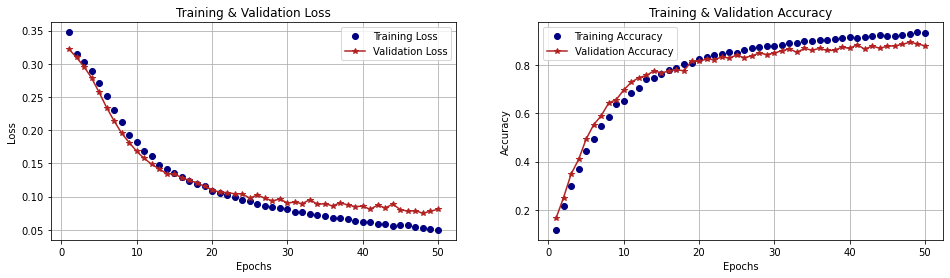

In [ ]:
print("CNN: Epochs={0:d}, Train accuracy={1:.5f}, Validation accuracy={2:.5f}".format(epochs,history.history['accuracy'][epochs-1],history.history['val_accuracy'][epochs-1]))
def show_plots(history):
    """ Useful function to view plot of loss values & accuracies across the various epochs """
    loss_vals = history['loss']
    val_loss_vals = history['val_loss']
    epochs = range(1, len(history['accuracy'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    # plot losses on ax[0]
    ax[0].plot(epochs, loss_vals, color='navy',marker='o', linestyle=' ', label='Training Loss')
    ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    # plot accuracies
    acc_vals = history['accuracy']
    val_acc_vals = history['val_accuracy']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
    # delete locals from heap before exiting
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals
show_plots(history.history)

In [ ]:
test_images = []
j = 39 # change this to get different images
for i in range(10):
    path = train_df[train_df.category == i].values[j] # 동물 10개의 이미지 path 정보
    
    # 이미지 불러오기
    a = images[train_df[train_df.filename == path[0]].index[0]]
    img = np.array(a)
    img = img[:, :, ::-1].copy() 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 이미지 전처리
    if(img.shape[0] > img.shape[1]):
        # 세로 이미지 변형
        tile_size = (int(img.shape[1]*256/img.shape[0]),256)
    else:
        # 가로 이미지 변형
        tile_size = (256, int(img.shape[0]*256/img.shape[1]))
        
    img = centering_image(cv2.resize(img, dsize=tile_size))
    img = img[16:240, 16:240]
    test_images.append(img) # 배열에 저장

# test 이미지 전처리
test_images = np.array(test_images).reshape(-1,224,224,3)

# 예측 결과값

In [ ]:
# 10번 예측 실행
something = model.predict(test_images)
predict_df = pd.DataFrame(something, columns = name_animal)
predict_df

,dog,horse,elephant,butterfly,chicken,cat,cow,sheep,spider,squirrel
0,1.0,0.000000,0.0,0.000000,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
1,0.0,0.000000,0.0,0.000000,0.0,0.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00
2,0.0,0.000000,1.0,0.000000,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
3,0.0,0.000000,0.0,1.000000,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
4,0.0,0.000000,0.0,0.000000,1.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
5,0.0,0.000000,0.0,0.000000,0.0,1.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
6,0.0,0.000000,0.0,0.000000,0.0,0.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00
7,0.0,0.000000,0.0,0.000000,0.0,0.000000e+00,1.0,3.569925e-23,0.000000e+00,0.000000e+00
8,0.0,0.020202,0.0,0.979798,0.0,8.620118e-15,0.0,0.000000e+00,3.443981e-11,4.171663e-37
9,0.0,0.000000,0.0,0.000000,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.000000e+00


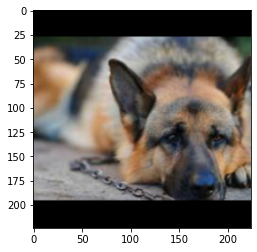

Actual  : dog
Predict : dog


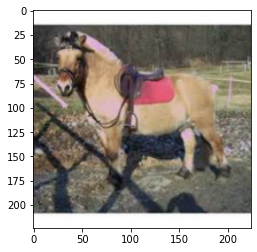

Actual  : horse
Predict : cow


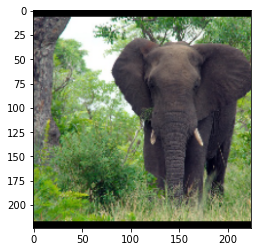

Actual  : elephant
Predict : elephant


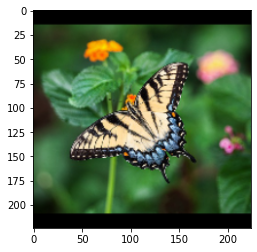

Actual  : butterfly
Predict : butterfly


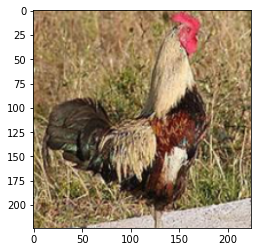

Actual  : chicken
Predict : chicken


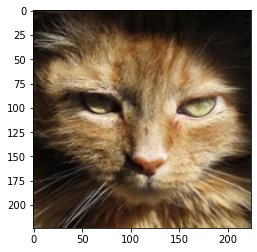

Actual  : cat
Predict : cat


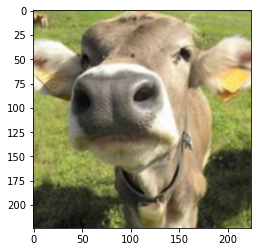

Actual  : cow
Predict : cow


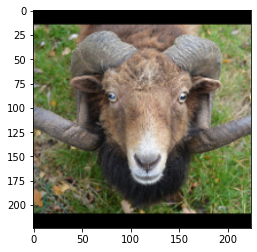

Actual  : sheep
Predict : cow


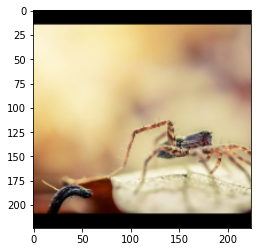

Actual  : spider
Predict : butterfly


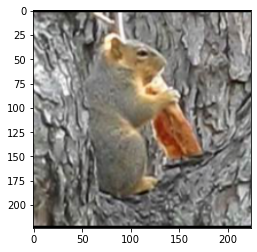

Actual  : squirrel
Predict : squirrel


In [ ]:
# 예측 결과
for i, pred in enumerate(something):
    path = train_df[train_df.category == i].values[2]
    plt.imshow(test_images[i])
    plt.show()
    print('Actual  :', animals[i])
    print('Predict :', animals[np.where(pred.max() == pred)[0][0]]) 